# Fitting a 2D Gaussian Tensor Train model to toy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

# setup path for repo imports
import sys, os
sys.path.append('../')

## Import Toy data

In [17]:
from data import to_tf_dataset
from data import gen_checkerboard as gen_data

# Number of datapoints to generate
N = 10000
batch_size = 64

# Generate toy data
data = gen_data(batch_size=N)

# Reserve some data for testing
x_val = data[-1000:]
x_train = data[:-1000]

# Prepare the datasets
ds_train = to_tf_dataset(x_train, batch_size=batch_size)
ds_val  = to_tf_dataset(x_val, batch_size=batch_size)

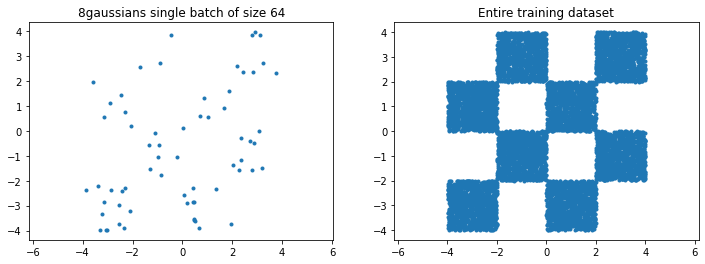

In [18]:
# Plot a single batch of the train dataset
single_batch = list(ds_train)[0]
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(single_batch[:, 0], single_batch[:, 1], '.')
ax[0].axis('equal')
ax[0].set_title(f'8gaussians single batch of size {batch_size}')
ax[1].plot(x_train[:, 0], x_train[:, 1], '.')
ax[1].axis('equal')
ax[1].set_title(f'Entire training dataset')
plt.show()

## Fit model to data

In [19]:
from models import TensorTrainGaussian2D

In [20]:
# create model
K = 5
model = TensorTrainGaussian2D(K)

# Instantiate an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [21]:
# Fit the model
EPOCHS = 20
# tf.config.run_functions_eagerly(True) # try to add this if you get an error
for epoch in range(EPOCHS):
    
    # Iterate over the batches of the dataset
    for i, x in enumerate(ds_train):
        loss_value = model.train_step(x, optimizer)

    print(
        "Training loss of last batch of epoch %d: %.4f"
        % (epoch + 1, float(loss_value))
    )

    # INSERT SOME KIND OF VALIDATION LOOP

Training loss of last batch of epoch 0: 4.1065
Training loss of last batch of epoch 1: 4.4343
Training loss of last batch of epoch 2: 4.2069
Training loss of last batch of epoch 3: 3.9715
Training loss of last batch of epoch 4: 4.0014
Training loss of last batch of epoch 5: 4.0282
Training loss of last batch of epoch 6: 3.9352
Training loss of last batch of epoch 7: 3.8113
Training loss of last batch of epoch 8: 3.8774
Training loss of last batch of epoch 9: 3.8131
Training loss of last batch of epoch 10: 3.8092
Training loss of last batch of epoch 11: 3.7245
Training loss of last batch of epoch 12: 3.6842
Training loss of last batch of epoch 13: 3.7794
Training loss of last batch of epoch 14: 3.7982
Training loss of last batch of epoch 15: 3.6609
Training loss of last batch of epoch 16: 3.7098
Training loss of last batch of epoch 17: 3.7109
Training loss of last batch of epoch 18: 3.7818
Training loss of last batch of epoch 19: 3.7326


0.9739253768282797

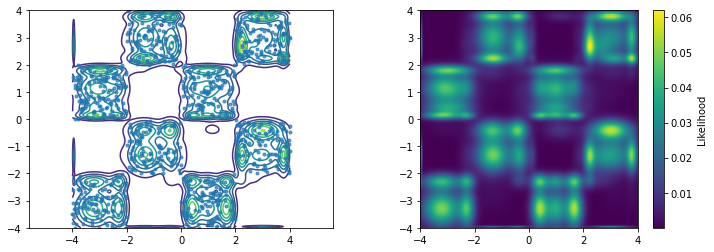

In [22]:
# Set number of points and limits
n_points = 1000
lim = 4

from utils import plot_contours, plot_density
f, ax = plt.subplots(1, 2, figsize=(12,4))
plot_contours(ax[0], x_val, model, lim, n_points)
plot_density(ax[1], model, lim, n_points)